# Deep Learning approach

### General algorithm

https://snap.stanford.edu/node2vec/

In [1]:
import networkx as nx 
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

In [2]:
def modularity(graph, community_nodes_list):
    
    L = len(list(graph.edges))
    subgraph = graph.subgraph(community_nodes_list)
    LC = len(list(subgraph.edges))
    k = 0
    for node in community_nodes_list:
        k += graph.degree(node)

    return ((LC/L)-(k/(2*L))**2)

In [3]:
def euclidean_dist(a,b):
    dist = 0
    if type(a)=='int':
        return ((a-b)**2)**0.5
    else:
        for i in range(len(a)):
            dist += (a[i]-b[i])**2
        return (dist)**0.5

In [4]:
# Prediction returning the ranking list of the edges
def prediction_directed(graph, emb_list, multi=False):
    
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    random.shuffle(nodes) # so that the prediction is not defined by the order of the nodes
    links = []
    distances = []
    
    for i in range(n):
        neighbors = [n for n in graph.neighbors(nodes[i])] # list of the neighbors of node i
        for j in range(n):
            if i != j :
                if (multi==False and nodes[j] not in neighbors) or (multi==True): 
                    # We don't want to predict edges already existing, if not multigraph
                    # if multigraph, we can predict another edge, where we already have one
                    links.append([nodes[i],nodes[j]]) 
                    distances.append(euclidean_dist(emb_list[nodes[i]],emb_list[nodes[j]]))
    
    Z = [x for _,x in sorted(zip(distances,links), reverse = False)]
    return Z

In [5]:
# Prediction returning the ranking list of the edges
def prediction_undirected(graph, emb_list, multi=False):
    
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    random.shuffle(nodes) # so that the prediction is not defined by the order of the nodes
    links = []
    distances = []
    
    for i in range(n):
        neighbors = [n for n in graph.neighbors(nodes[i])] # list of the neighbors of node i
        for j in range(i+1,n):
            if (multi==False and nodes[j] not in neighbors) or (multi==True): 
                # We don't want to predict edges already existing, if not multigraph
                # if multigraph, we can predict if there is another edge, where we already have one
                # in the notation of the dataset the first number is always the smaller one of the vertices linked by an edge
                links.append([min(nodes[i],nodes[j]),max(nodes[i],nodes[j])]) 
                distances.append(euclidean_dist(emb_list[nodes[i]],emb_list[nodes[j]]))
    
    Z = [x for _,x in sorted(zip(distances,links), reverse = False)]
    return Z

In [6]:
# function giving all kind of results on performance

def results(predictions, actual_edges, graph):
    
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    n_edges = graph.number_of_edges()
    test_size = len(actual_edges)
    
    precisions = []
    recalls = []
    fp_rates = []
    MAP = 0
    tp = 0
    fp = 0
    tn = len(predictions)-test_size # when 0 positive is predicted
    fn = test_size # when 0 positive is predicted
    #k = len(predictions) # number of edges predicted
    
    
    for k in range(len(predictions)):
        
        if k == test_size and tp != 0:
            MAP = MAP / tp
            
        if predictions[k] in actual_edges:
            tp += 1
            fn -= 1  
            if k<test_size:
                MAP += (tp /(tp + fp))   
        else:
            fp += 1
            tn -= 1

        if (tp != 0 or fp != 0) and k<test_size:
            # average precision for k=test_size
            # precision = tp /(tp + fp)
            precisions.append(tp/(tp + fp))
            
        if tp != 0 or fn != 0:
        # tp + fn = relevant_edges
            recalls.append(tp/(tp + fn))                 
        if tn != 0 or fp != 0:
            # tn + fp = num_vertices*(num_vertices-1) - num_edges - relevant_edges = irrelevant_edges
            fp_rates.append(fp/(tn + fp))
                
    if tp == 0:  # Not even one good prediction
        return [0]*test_size,0,[0]*(k+1),[0]*(k+1)
    
    return(precisions,MAP,recalls,fp_rates)

In [7]:
# Average results for the 5-CrossValidation

def CV_results(list_graphs, list_targets, emb_list, network_type='undirected', multi=False):
    test_size = len(list_targets[0])
    precisions, MAP, recalls, fp_rates= [0]*test_size,0,[],[]
    
    for part in range(5):
        
        if network_type == 'directed':
            predictions = prediction_directed(list_graphs[part],emb_list,multi)
        else: predictions = prediction_undirected(list_graphs[part],emb_list,multi)
            
        if recalls == [] and fp_rates == []:
            recalls, fp_rates = [0]*len(predictions),[0]*len(predictions)
        precisions_N, MAP_N, recalls_N, fp_rates_N = results(predictions,list_targets[part],list_graphs[part])
        precisions,MAP,recalls,fp_rates = [sum(x) for x in zip(precisions,precisions_N)] ,MAP+MAP_N, [sum(x) for x in zip(recalls,recalls_N)], [sum(x) for x in zip(fp_rates,fp_rates_N)]
  
    return([x/5 for x in precisions], MAP/5, [x/5 for x in recalls], [x/5 for x in fp_rates])

In [8]:
def AUROC(fp_rates,recalls):
    score = 0
    
    for x in range(1,len(fp_rates)):
        score += (fp_rates[x]-fp_rates[x-1])*recalls[x]
        
    return score

Hierarchical clustering from: https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

### First dataset : PROTEINS

The first dataset we work on is a network of the interactions between human proteins.
It makes a perfect example of one of the important applications of link prediction: the
biologic domain. It is a directed, unweighted network composed of 1706 vertices
(proteins) and 6,207 edges (interactions).

In [9]:
# Importation of the node embeddings
PROT_emb = []
with open('node2vec-master\emb\PROT.emb') as inputfile:
    for line in inputfile:
        PROT_emb.append(line.strip())
PROT_emb = PROT_emb[1:] # list of all the node embeddings

# We create 2 lists to store the embeddings and the corresponding nodes
# and a dictionary easier to provide the embeddings giving a node
PROT_EMB = list()
PROT_EMB_nodes = list()
PROT_EMB_data = dict()

for node_emb in PROT_emb:
    node = list(np.float_(node_emb.split(' '))) # each number is also converted from a string to a float 
    PROT_EMB_data[node[0]] = node[1:]
    PROT_EMB_nodes.append(node[0])
    PROT_EMB.append(node[1:])

In [10]:
# Importation of the dataset: PROTEINS
# http://konect.uni-koblenz.de/networks/maayan-Stelzl 

PROT = []
with open('out.maayan-Stelzl') as inputfile:
    for line in inputfile:
        PROT.append(line.strip().split(','))
PROT = PROT[1:] # list of all the edges
random.shuffle(PROT) # we randomly shuffle the edges

# test size
num_edges_PROT = len(PROT)
num_vertices_PROT = 1706
test_size_PROT = int(num_edges_PROT/5)

# Contains the 5 parts forming the whole dataset
parts_PROT = []

start = 0
end = test_size_PROT
for part in range(5):  # We create the 5 parts
    if end>num_edges_PROT:
        parts_PROT.append(PROT[start:])
    else:parts_PROT.append(PROT[start:end])
    start = end
    end = start + test_size_PROT

In [11]:
PROT_G = nx.DiGraph()
for edge in range(len(PROT)):
    nodes = PROT[edge][0].split(' ')
    PROT_G.add_edge(int(nodes[0]), int(nodes[1]))
PROT_nodes = PROT_G.nodes()

In [12]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

PROT_graphs = []
PROT_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.DiGraph()
    G.add_nodes_from(PROT_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_PROT[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                target_links.append([int(nodes[0]),int(nodes[1])])            

    PROT_graphs.append(G)
    PROT_targets.append(target_links)

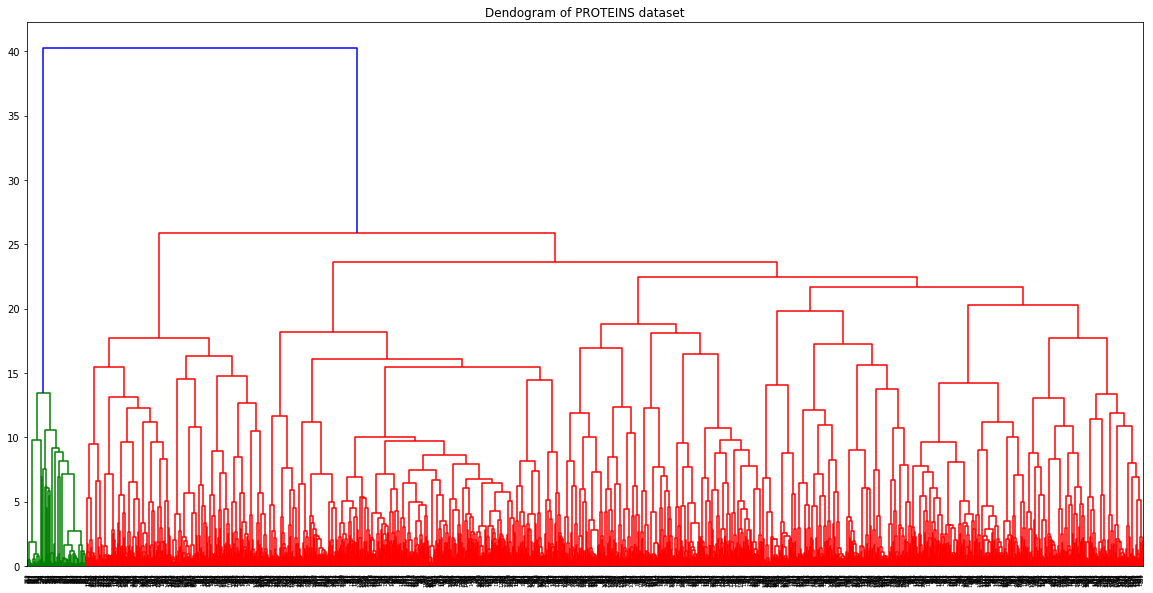

In [13]:
plt.figure(figsize=(20, 10))  
plt.title("Dendogram of PROTEINS dataset")  
dend = shc.dendrogram(shc.linkage(PROT_EMB, method='ward')) 

If we draw a horizontal line that passes through longest distance without a horizontal line, we get 2 clusters as we can see it in the following figure:




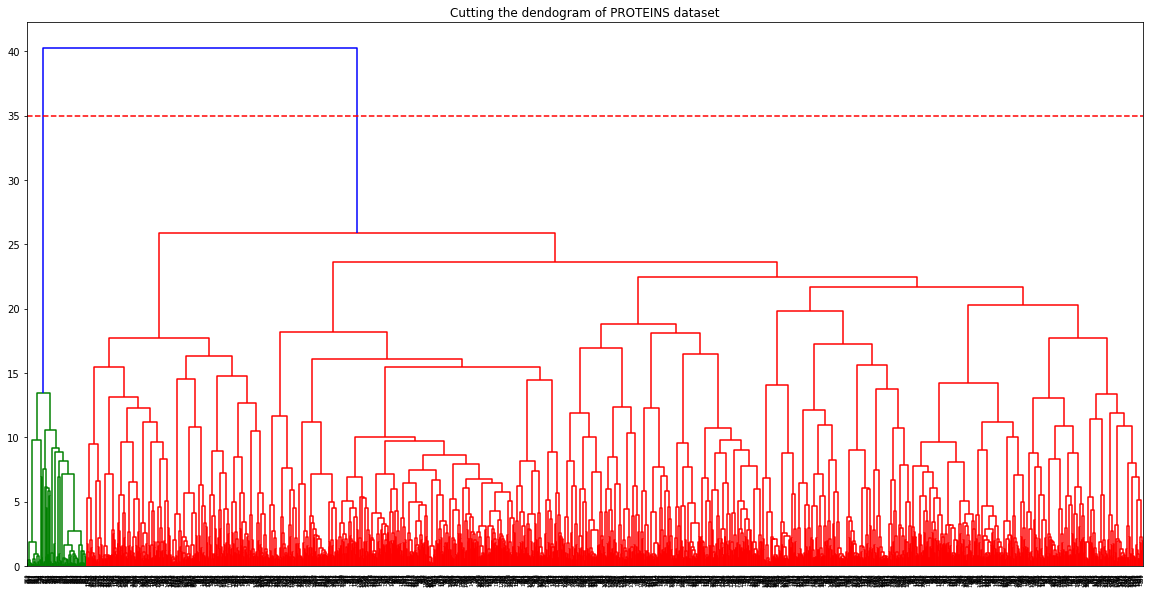

In [14]:
plt.figure(figsize=(20, 10))  
plt.title("Cutting the dendogram of PROTEINS dataset")  
dend = shc.dendrogram(shc.linkage(PROT_EMB, method='ward')) 
plt.axhline(y=35, color='r', linestyle='--')

In [15]:
# Clustering
PROT_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
PROT_cluster.fit_predict(PROT_EMB)  

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [16]:
# List of the different clusters
PROT_list0 = list()
PROT_list1 = list()

for x in range(len(PROT_cluster.labels_)):
    if PROT_cluster.labels_[x] == 0:
        PROT_list0.append(int(PROT_EMB_nodes[x]))
    if PROT_cluster.labels_[x] == 1:
        PROT_list1.append(int(PROT_EMB_nodes[x]))   

In [69]:
print(modularity(PROT_G,PROT_list0)+modularity(PROT_G,PROT_list1))

0.032310026184596476


In [18]:
score = 0
n = 0
for i in PROT_list0:
    neighbors = [n for n in PROT_G.neighbors(i)]
    for j in PROT_list1:
        n += 1
        if j in neighbors:
            score += 1
print(score/n)

2.0413023508998743e-05


There is almost no link between the two clusters, which validates the efficiency of the clustering of the nodes.

In [19]:
precisions,MAP,recalls,fp_rates = CV_results(PROT_graphs,PROT_targets, PROT_EMB_data, 'directed')

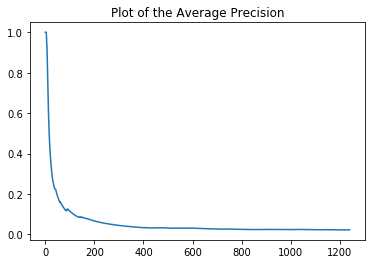

In [20]:
plt.figure()
X = [x for x in range(len(precisions))]
plt.plot(X,precisions)
plt.title('Plot of the Average Precision')
plt.show()

First with a high precision which then slowly decreases, the ranking is good.

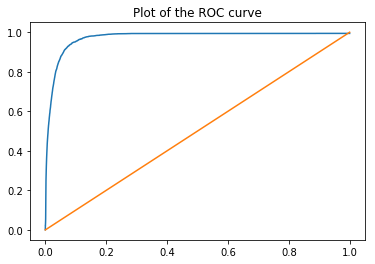

In [21]:
plt.figure()
plt.plot(fp_rates, recalls, fp_rates,fp_rates )
plt.title('Plot of the ROC curve')
plt.show()

In [22]:
AUROC(fp_rates, recalls)

0.9717178619684582

In [23]:
MAP

0.33840240209180067

### Second dataset: INFECTIOUS

The second dataset we work on is a network representing the face-to-face behaviour of
people during the exhibition INFECTIOUS: STAY AWAY in 2009 at the Science Gallery
in Dublin. It is undirected, unweighted but has multiple edges. It is composed of 410
vertices (visitors) and 17,298 edges (human face-to-face).

In [24]:
# Importation of the node embeddings
INF_emb = []
with open('node2vec-master\emb\INF.emb') as inputfile:
    for line in inputfile:
        INF_emb.append(line.strip())
INF_emb = INF_emb[1:] # list of all the node embeddings

# We create 2 lists to store the embeddings and the corresponding nodes
# and a dictionary easier to provide the embeddings giving a node
INF_EMB_nodes = list()
INF_EMB = list()
INF_EMB_data = dict()

for node_emb in INF_emb:
    node = list(np.float_(node_emb.split(' '))) # each number is also converted from a string to a float 
    INF_EMB_data[node[0]] = node[1:]
    INF_EMB_nodes.append(node[0])
    INF_EMB.append(node[1:])

In [25]:
# Importation of the dataset: INFECTIOUS
# http://konect.uni-koblenz.de/networks/sociopatterns-infectious 

INF = []
with open('sociopatterns-infectious\out.sociopatterns-infectious') as inputfile:
    for line in inputfile:
        INF.append(line.strip().split(','))
INF = INF[2:] # list of all the edges
random.shuffle(INF) # we randomly shuffle the edges

# test size
num_edges_INF = len(INF)
num_vertices_INF = 410
test_size_INF = int(num_edges_INF/5)

# Contains the 5 parts forming the whole dataset
parts_INF = []

start = 0
end = test_size_INF
for part in range(5):  # We create the 5 parts
    if end>num_edges_INF:
        parts_INF.append(INF[start:])
    else:parts_INF.append(INF[start:end])
    start = end
    end = start + test_size_INF

In [26]:
INF_G = nx.MultiGraph()
for edge in range(len(INF)):
    nodes = INF[edge][0].split(' ')
    INF_G.add_edge(int(nodes[0]), int(nodes[1])) 
INF_nodes = INF_G.nodes()

In [27]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

INF_graphs = []
INF_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.MultiGraph()
    G.add_nodes_from(INF_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_INF[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                # For undirected network, we write the min node first
                # We don't want duplicates because we can only predict an edge once
                # We cannot predict the number of edges to add
                if [min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))] not in target_links:
                    target_links.append([min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))])
                
    INF_graphs.append(G)
    INF_targets.append(target_links) 

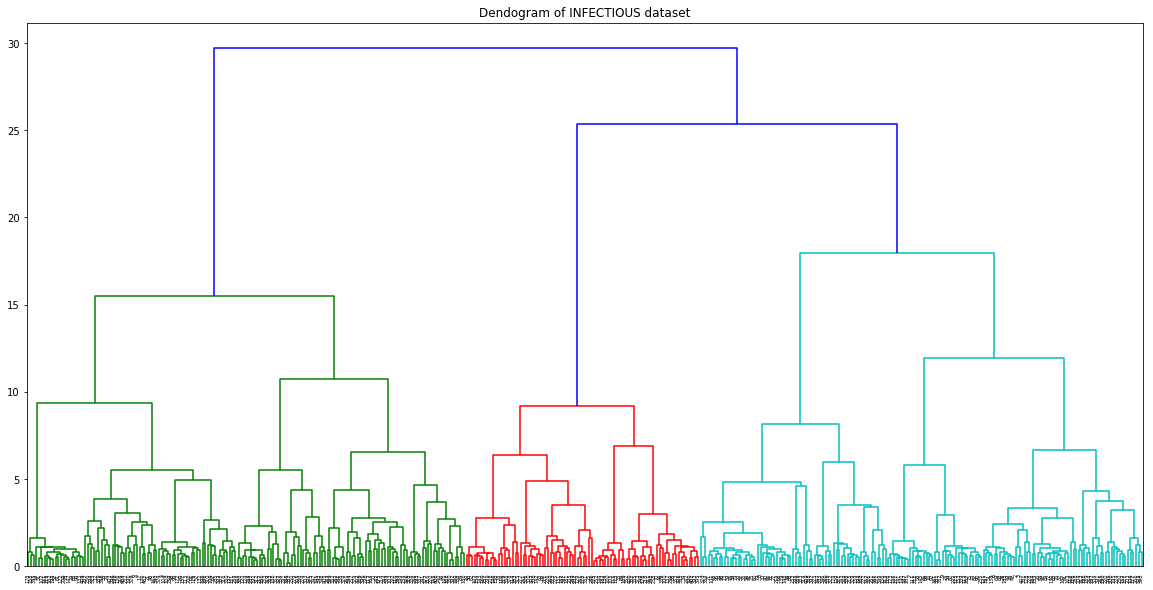

In [28]:
plt.figure(figsize=(20, 10))  
plt.title("Dendogram of INFECTIOUS dataset")  
dend = shc.dendrogram(shc.linkage(INF_EMB, method='ward')) 

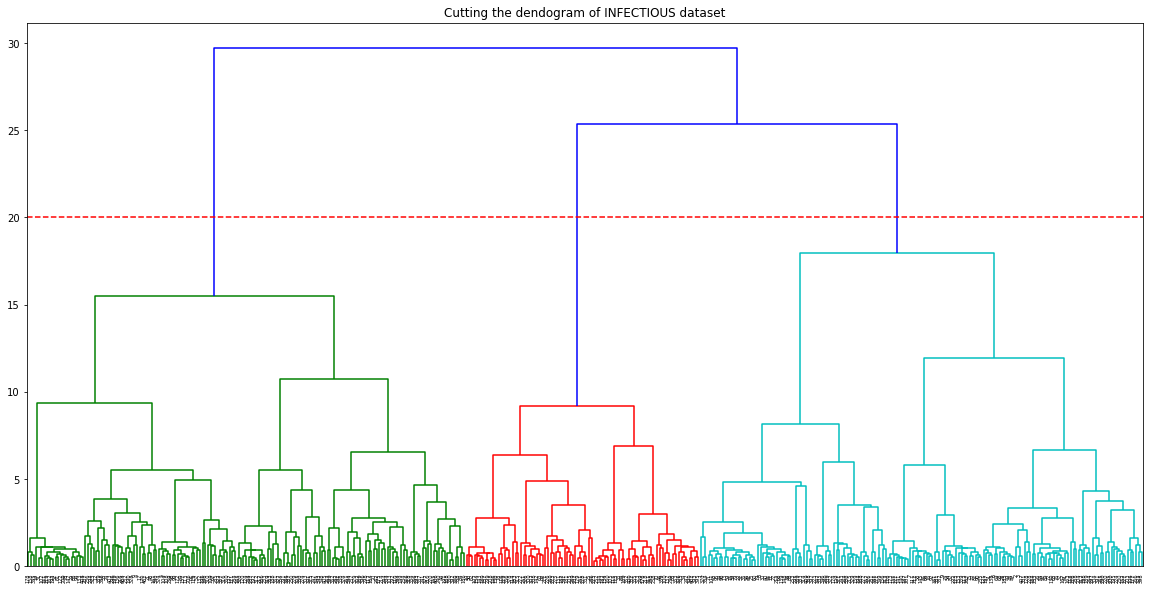

In [29]:
plt.figure(figsize=(20, 10))  
plt.title("Cutting the dendogram of INFECTIOUS dataset")  
dend = shc.dendrogram(shc.linkage(INF_EMB, method='ward')) 
plt.axhline(y=20, color='r', linestyle='--')

In [30]:
# Clustering
INF_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
INF_cluster.fit_predict(INF_EMB)  

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 2, 0, 1, 1,
       0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0,
       0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 2, 1, 0,
       0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 2, 0, 2, 1, 1,
       1, 0, 0, 1, 2, 2, 2, 1, 0, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 2,
       1, 1, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 1, 0, 1, 2, 1, 0, 0,
       2, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 1,
       2, 0, 1, 2, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 2, 0, 0, 2, 1, 1, 2, 1, 1, 2, 0, 0, 1, 0, 1, 1, 2, 1,
       0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1,
       2, 0, 1, 0, 1, 1, 2, 2, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 2, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 2, 0, 0, 2, 1, 0, 0, 1, 2, 1, 1,
       2, 1, 0, 2, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 2,

In [31]:
# List of the different clusters
INF_list0 = list()
INF_list1 = list()
INF_list2 = list()

for x in range(len(INF_cluster.labels_)):
    if INF_cluster.labels_[x] == 0:
        INF_list0.append(int(INF_EMB_nodes[x]))
    if INF_cluster.labels_[x] == 1:
        INF_list1.append(int(INF_EMB_nodes[x]))  
    if INF_cluster.labels_[x] == 2:
        INF_list2.append(int(INF_EMB_nodes[x])) 

In [72]:
print(modularity(INF_G,INF_list0)+modularity(INF_G,INF_list1)+modularity(INF_G,INF_list2))

0.6048094085730751


In [33]:
score = 0
t = 0
for i in INF_list0:
    neighbors = [n for n in INF_G.neighbors(i)]
    for j in INF_list1:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in INF_list0:
    neighbors = [n for n in INF_G.neighbors(i)]
    for j in INF_list2:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in INF_list2:
    neighbors = [n for n in INF_G.neighbors(i)]
    for j in INF_list1:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

0.004839385740959494
0.0038521900413753746
0.0001444460494005489


In [34]:
precisions_INF, MAP_INF, recalls_INF, fp_rates_INF = CV_results(INF_graphs,INF_targets,INF_EMB_data,'undirected',True)

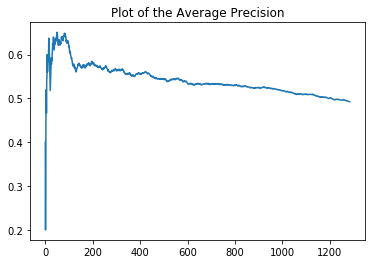

In [35]:
plt.figure()
X_INF = [x for x in range(len(precisions_INF))]
plt.plot(X_INF,precisions_INF)
plt.title('Plot of the Average Precision')
plt.show()

The precision is high and then decreases which characterise a good ranking. However, we see some little peaks, like little irregularities.

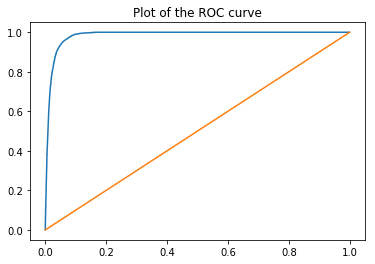

In [36]:
plt.figure()
plt.plot(fp_rates_INF, recalls_INF, fp_rates_INF,fp_rates_INF )
plt.title('Plot of the ROC curve')
plt.show()

In [37]:
AUROC(fp_rates_INF, recalls_INF)

0.9845226007770227

In [38]:
MAP_INF

0.5459022086479484

### Third dataset: ADOLESCENT

The third dataset is also social related. It has been created from a survey that took place
in 1994/1995. Each student was asked to list his 5 best female and his 5 male friends. The
network is composed of 2,539 vertices (students), and 12,969 edges (friendships). It is
directed and weighted. The bigger the weight of an edge is the more important the
relation is.

In [39]:
# Importation of the node embeddings
ADO_emb = []
with open('node2vec-master\emb\ADO.emb') as inputfile:
    for line in inputfile:
        ADO_emb.append(line.strip())
ADO_emb = ADO_emb[1:] # list of all the node embeddings

# We create 2 lists to store the embeddings and the corresponding nodes
# and a dictionary easier to provide the embeddings giving a node
ADO_EMB_data = dict()
ADO_EMB_nodes = list()
ADO_EMB = list()

for node_emb in ADO_emb:
    node = list(np.float_(node_emb.split(' '))) # each number is also converted from a string to a float 
    ADO_EMB_data[node[0]] = node[1:]
    ADO_EMB_nodes.append(node[0])
    ADO_EMB.append(node[1:])

In [40]:
# Importation of the dataset: ADOLESCENT
# http://konect.uni-koblenz.de/networks/moreno_health

ADO = []
with open('moreno_health\out.moreno_health_health') as inputfile:
    for line in inputfile:
        ADO.append(line.strip().split(','))
ADO = ADO[2:] # list of all the edges
random.shuffle(ADO) # we randomly shuffle the edges

# test size
num_edges_ADO = len(ADO)
num_vertices_ADO = 2539
test_size_ADO = int(num_edges_ADO/5)

# Contains the 5 parts forming the whole dataset
parts_ADO = []

start = 0
end = test_size_ADO
for part in range(5):  # We create the 5 parts
    if end>num_edges_ADO:
        parts_ADO.append(ADO[start:])
    else:parts_ADO.append(ADO[start:end])
    start = end
    end = start + test_size_ADO


In [41]:
ADO_G = nx.DiGraph()
for edge in range(len(ADO)):
    nodes = ADO[edge][0].split(' ')
    ADO_G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2]))
ADO_nodes = ADO_G.nodes()

In [42]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

ADO_graphs = []
ADO_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.DiGraph()
    G.add_nodes_from(ADO_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_ADO[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                target_links.append([int(nodes[0]),int(nodes[1])])
                
                

    ADO_graphs.append(G)
    ADO_targets.append(target_links)
  

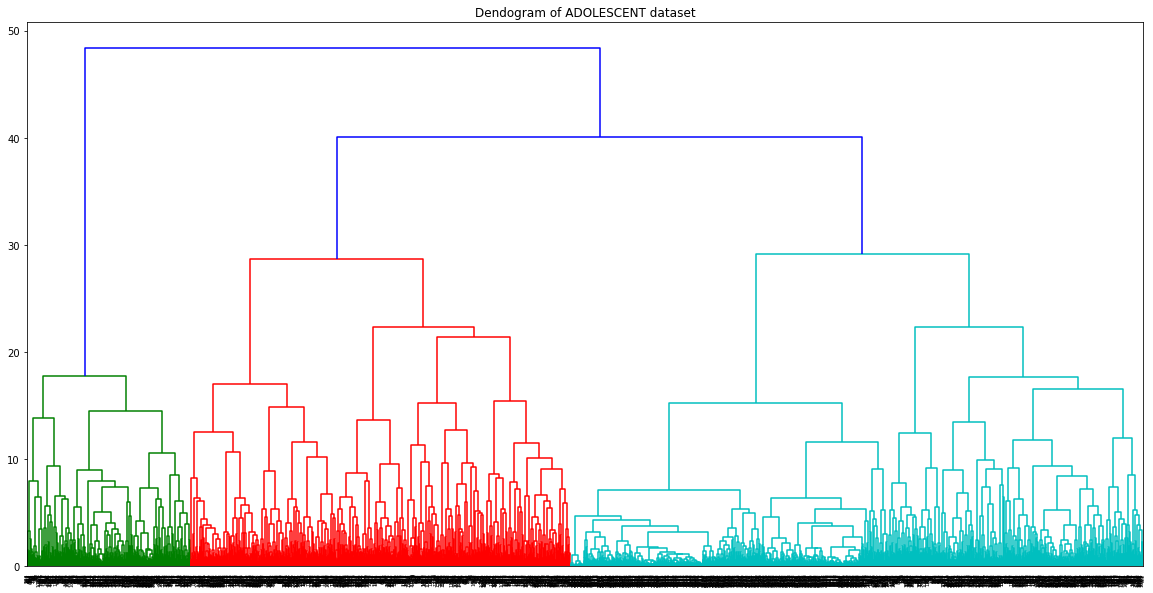

In [43]:
plt.figure(figsize=(20, 10))  
plt.title("Dendogram of ADOLESCENT dataset")  
dend = shc.dendrogram(shc.linkage(ADO_EMB, method='ward')) 

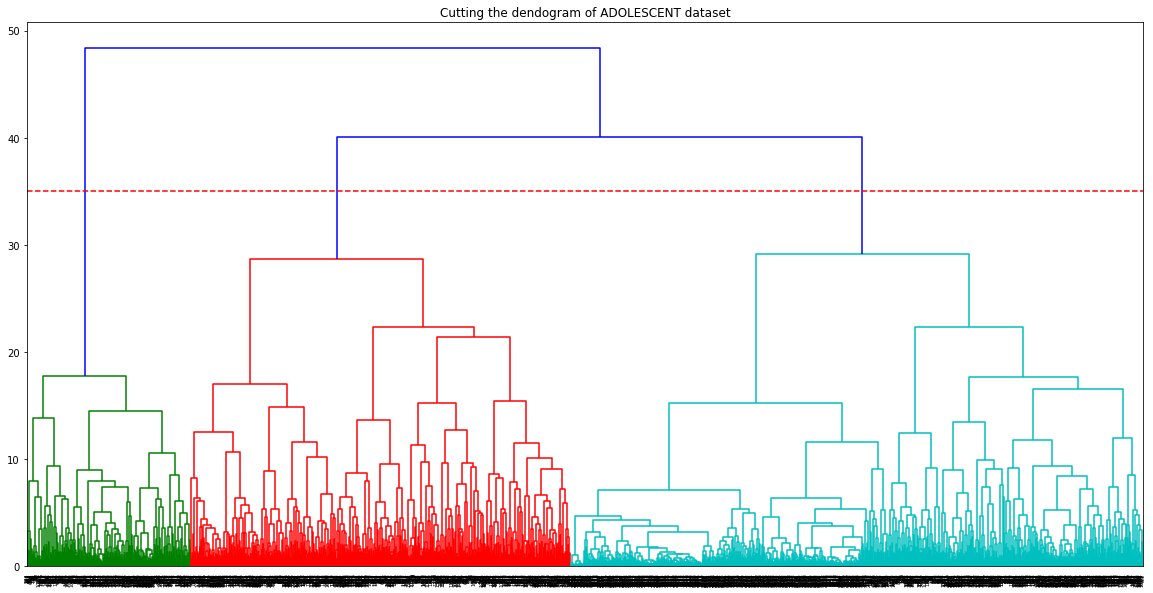

In [44]:
plt.figure(figsize=(20, 10))  
plt.title("Cutting the dendogram of ADOLESCENT dataset")  
dend = shc.dendrogram(shc.linkage(ADO_EMB, method='ward')) 
plt.axhline(y=35, color='r', linestyle='--')

In [45]:
# Clustering
ADO_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
ADO_cluster.fit_predict(ADO_EMB)  

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [46]:
# List of the different clusters
ADO_list0 = list()
ADO_list1 = list()
ADO_list2 = list()
for x in range(len(ADO_cluster.labels_)):
    if ADO_cluster.labels_[x] == 0:
        ADO_list0.append(int(ADO_EMB_nodes[x]))
    if ADO_cluster.labels_[x] == 1:
        ADO_list1.append(int(ADO_EMB_nodes[x]))  
    if ADO_cluster.labels_[x] == 2:
        ADO_list2.append(int(ADO_EMB_nodes[x])) 

In [70]:
print(modularity(ADO_G,ADO_list0)+modularity(ADO_G,ADO_list1)+modularity(ADO_G,ADO_list2))

0.44087915035694797


In [48]:
score = 0
t = 0
for i in ADO_list0:
    neighbors = [n for n in ADO_G.neighbors(i)]
    for j in ADO_list1:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in ADO_list0:
    neighbors = [n for n in ADO_G.neighbors(i)]
    for j in ADO_list2:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in ADO_list2:
    neighbors = [n for n in ADO_G.neighbors(i)]
    for j in ADO_list1:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

0.001198640028387757
0.0009557715812512435
9.956192751891676e-05


In [49]:
precisions_ADO,MAP_ADO,recalls_ADO,fp_rates_ADO = CV_results(ADO_graphs,ADO_targets,ADO_EMB_data,'directed')

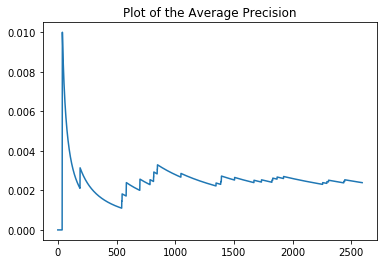

In [50]:
plt.figure()
X_ADO = [x for x in range(len(precisions_ADO))]
plt.plot(X_ADO,precisions_ADO)
plt.title('Plot of the Average Precision')
plt.show()

The precision is high and then decreases which characterise a good ranking. However, we see some little peaks, like little irregularities.

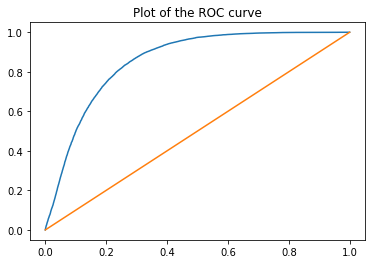

In [51]:
plt.figure()
plt.plot(fp_rates_ADO, recalls_ADO, fp_rates_ADO,fp_rates_ADO )
plt.title('Plot of the ROC curve')
plt.show()

In [52]:
AUROC(fp_rates_ADO, recalls_ADO)

0.8550052838477304

In [53]:
MAP_ADO

0.0056806593259406905

### Fourth dataset: MISERABLES

The last dataset is entirely different since it is pure fiction. It contains co-occurrences of
characters in Victor Hugo's novel Les Misérables. The network is undirected and positive
weighted. It is composed of 77 vertices (the characters), 254 edges (co-occurrences in a
chapter).

In [54]:
# Importation of the node embeddings
MIS_emb = []
with open('node2vec-master\emb\MIS.emb') as inputfile:
    for line in inputfile:
        MIS_emb.append(line.strip())
MIS_emb = MIS_emb[1:] # list of all the node embeddings

# We create 2 lists to store the embeddings and the corresponding nodes
# and a dictionary easier to provide the embeddings giving a node
MIS_EMB_data = dict()
MIS_EMB = list()
MIS_EMB_nodes = list()

for node_emb in MIS_emb:
    node = list(np.float_(node_emb.split(' '))) # each number is also converted from a string to a float 
    MIS_EMB_data[node[0]] = node[1:]
    MIS_EMB_nodes.append(node[0])
    MIS_EMB.append(node[1:])

In [55]:
# Importation of the dataset: MISERABLES
# http://konect.uni-koblenz.de/networks/moreno_lesmis

MIS = []
with open('moreno_lesmis\out.moreno_lesmis_lesmis') as inputfile:
    for line in inputfile:
        MIS.append(line.strip().split(','))
MIS = MIS[2:] # list of all the edges
random.shuffle(MIS) # we randomly shuffle the edges

# test size
num_edges_MIS = len(MIS)
num_vertices_MIS = 77
test_size_MIS = int(num_edges_MIS/5)

# Contains the 5 parts forming the whole dataset
parts_MIS = []

start = 0
end = test_size_MIS
for part in range(5):  # We create the 5 parts
    if end>num_edges_MIS:
        parts_MIS.append(MIS[start:])
    else:parts_MIS.append(MIS[start:end])
    start = end
    end = start + test_size_MIS

In [56]:
MIS_G = nx.Graph()
for edge in range(len(MIS)):
    nodes = MIS[edge][0].split(' ')
    MIS_G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2]))
MIS_nodes = MIS_G.nodes()

In [57]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

MIS_graphs = []
MIS_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.Graph()
    G.add_nodes_from(MIS_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_MIS[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                # For undirected network, we write the min node first
                target_links.append([min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))])
                
    MIS_graphs.append(G)
    MIS_targets.append(target_links)

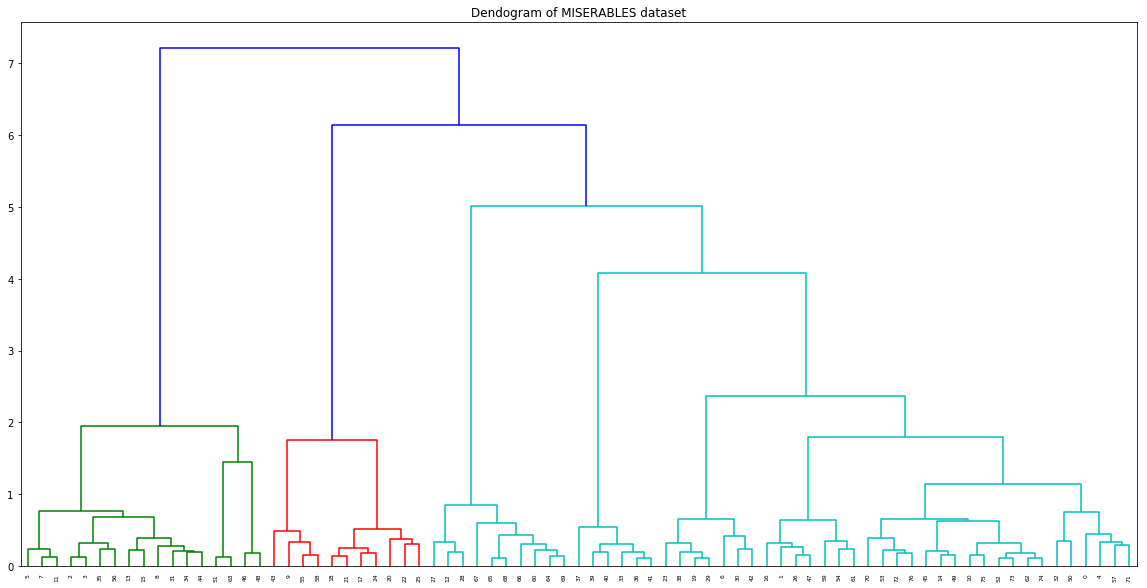

In [58]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 10))  
plt.title("Dendogram of MISERABLES dataset")  
dend = shc.dendrogram(shc.linkage(MIS_EMB, method='ward')) 

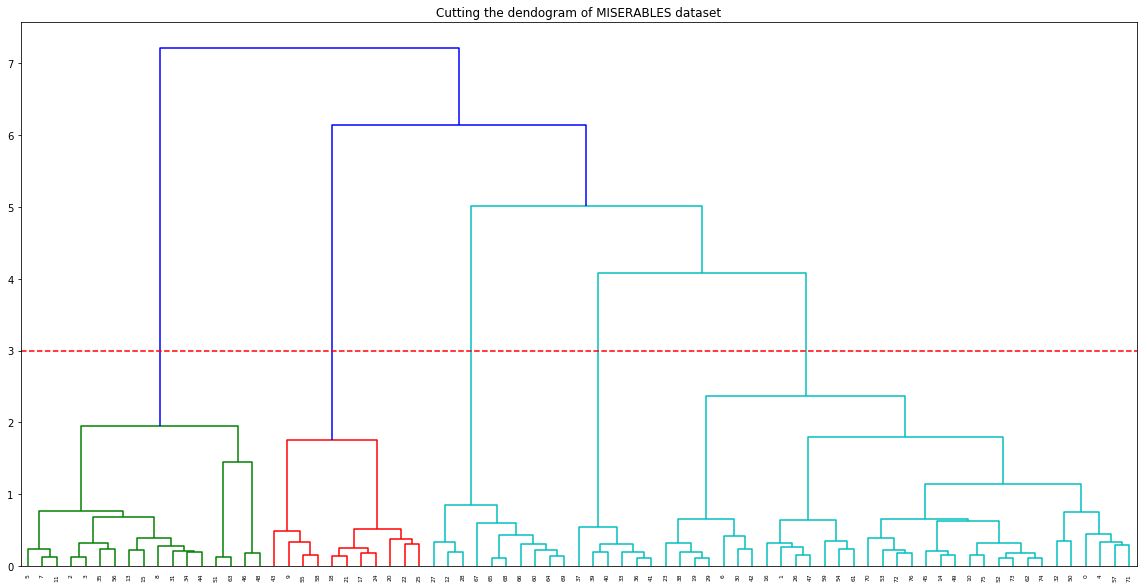

In [59]:
plt.figure(figsize=(20, 10))  
plt.title("Cutting the dendogram of MISERABLES dataset")  
dend = shc.dendrogram(shc.linkage(MIS_EMB, method='ward')) 
plt.axhline(y=3, color='r', linestyle='--')

In [60]:
MIS_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
MIS_cluster.fit_predict(MIS_EMB)  

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 2, 0, 1, 3, 1, 0, 1, 0, 2, 2, 0, 2, 2,
       2, 0, 2, 2, 0, 3, 3, 0, 0, 1, 0, 4, 1, 1, 4, 4, 0, 4, 4, 4, 0, 2,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 0, 2, 0, 3, 0, 0, 1, 3, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [61]:
# List of the different clusters
MIS_list0 = list()
MIS_list1 = list()
MIS_list2 = list()
MIS_list3 = list()
MIS_list4 = list()

for x in range(len(MIS_cluster.labels_)):
    if MIS_cluster.labels_[x] == 0:
        MIS_list0.append(int(MIS_EMB_nodes[x]))
    if MIS_cluster.labels_[x] == 1:
        MIS_list1.append(int(MIS_EMB_nodes[x]))  
    if MIS_cluster.labels_[x] == 2:
        MIS_list2.append(int(MIS_EMB_nodes[x]))
    if MIS_cluster.labels_[x] == 3:
        MIS_list3.append(int(MIS_EMB_nodes[x]))
    if MIS_cluster.labels_[x] == 4:
        MIS_list4.append(int(MIS_EMB_nodes[x]))

In [71]:
print(modularity(MIS_G,MIS_list0)+modularity(MIS_G,MIS_list1)+modularity(MIS_G,MIS_list2)+modularity(MIS_G,MIS_list3)+modularity(MIS_G,MIS_list4))

0.5280318060636121


In [63]:
score = 0
t = 0
for i in MIS_list0:
    neighbors = [n for n in MIS_G.neighbors(i)]
    for j in MIS_list1:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in MIS_list0:
    neighbors = [n for n in MIS_G.neighbors(i)]
    for j in MIS_list2:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in MIS_list3:
    neighbors = [n for n in MIS_G.neighbors(i)]
    for j in MIS_list1:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in MIS_list4:
    neighbors = [n for n in MIS_G.neighbors(i)]
    for j in MIS_list1:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in MIS_list1:
    neighbors = [n for n in MIS_G.neighbors(i)]
    for j in MIS_list2:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in MIS_list1:
    neighbors = [n for n in MIS_G.neighbors(i)]
    for j in MIS_list3:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in MIS_list1:
    neighbors = [n for n in MIS_G.neighbors(i)]
    for j in MIS_list4:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in MIS_list2:
    neighbors = [n for n in MIS_G.neighbors(i)]
    for j in MIS_list3:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in MIS_list2:
    neighbors = [n for n in MIS_G.neighbors(i)]
    for j in MIS_list4:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

score = 0
t = 0
for i in MIS_list3:
    neighbors = [n for n in MIS_G.neighbors(i)]
    for j in MIS_list4:
        t += 1
        if j in neighbors:
            score += 1
print(score/t)

0.0392156862745098
0.024793388429752067
0.0
0.0
0.0
0.0
0.0
0.0
0.015151515151515152
0.0


In [64]:
precisions_MIS, MAP_MIS, recalls_MIS, fp_rates_MIS = CV_results(MIS_graphs, MIS_targets, MIS_EMB_data)

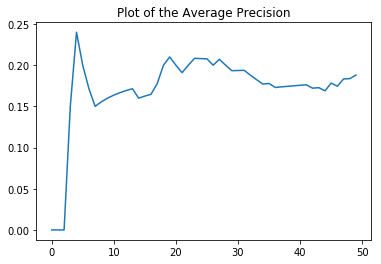

In [65]:
plt.figure()
X_MIS = [x for x in range(len(precisions_MIS))]
plt.plot(X_MIS,precisions_MIS)
plt.title('Plot of the Average Precision')
plt.show()

The precision is high and then decreases in average which characterise a quite good ranking. However, we see some peaks, like irregularities.

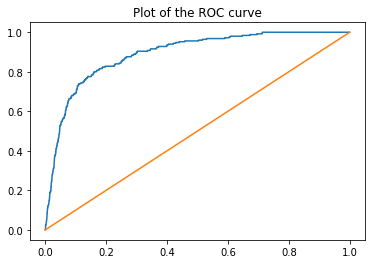

In [66]:
plt.figure()
plt.plot(fp_rates_MIS, recalls_MIS, fp_rates_MIS,fp_rates_MIS )
plt.title('Plot of the ROC curve')
plt.show()

In [67]:
AUROC(fp_rates_MIS, recalls_MIS)

0.8900816143497834

In [68]:
MAP_MIS

0.21298230552698266